### Lightning Debug

In this notebook we debug the Lightning, i.e. focus on it's execution speed. Since Lightning was generaly slower in our examples, we'll perform the tests using `scratch`.

In [68]:
from benchmarking.analysis.analyze_results import *

In [69]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/lightning_debug")

In [70]:
scratch_folder_filter="logging/*benchmark_e2e_*"

Load the data

In [71]:
def timelines(df, run, lanes, colors, flat=False, zoom=False, zoom_epochs=1, title=""):
    start = min(df["start_time_x"])
    end = max(df["end_time_y"])

    i = 0
    for _, row in df.sort_values(["start_time_x"], ascending=True).iterrows():
        duration = row["end_time_y"] - row["start_time_x"]
        x1 = row["start_time_x"] - start
        x2 = x1 + duration
        if not flat:
            lane = i
            i += 1
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=2)
    ax.set_xlabel("Experiment duration", loc="center")
    ax.set_ylabel("Item", loc="top")
    filename = run.split("_")
    ax.set_title(title, loc="center")
    ax.legend()
    ax.grid(linestyle="--", which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(
        by_label.values(),
        by_label.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=5,
    )


In [72]:
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 234.34it/s]


Find unique functions for later sorting, and assign them with colors, that will represent their execution lines in the timeline plot.

In [73]:
unique_functions = np.sort(np.unique(df_dataloader_scratch["item_x"]))
named_colors = ["green", "orange", "lawngreen", "black", "gray", "teal"]
print(unique_functions)

# ensure that special functions (same for both Lightning and Torch approach) are always plotted in the same color
colors = {}
special_functions = ["batch", "training_batch_to_device", "run_training_batch"]
unique_functions = np.setdiff1d(unique_functions, special_functions)

for i, color in zip(special_functions, ["red", "magenta", "blue"]):
    colors[str(i)] = color
for i, color in zip(unique_functions, named_colors):
    colors[str(i)] = color    
print(colors)


lanes={}
for i, lane in zip(unique_functions, range(len(unique_functions_scratch))):
    lanes[str(i)] = lane
    
print(f"Lanes: {lanes}")

unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

['advance' 'batch' 'next_data' 'postrun_training_batch'
 'prep_training_batch' 'prerun' 'reset_timeline' 'run_training_batch'
 'training_batch_to_device']
{'batch': 'red', 'training_batch_to_device': 'magenta', 'run_training_batch': 'blue', 'advance': 'green', 'next_data': 'orange', 'postrun_training_batch': 'lawngreen', 'prep_training_batch': 'black', 'prerun': 'gray', 'reset_timeline': 'teal'}
Lanes: {'advance': 0, 'next_data': 1, 'postrun_training_batch': 2, 'prep_training_batch': 3, 'prerun': 4, 'reset_timeline': 5}


Extract the GPU Utilization data

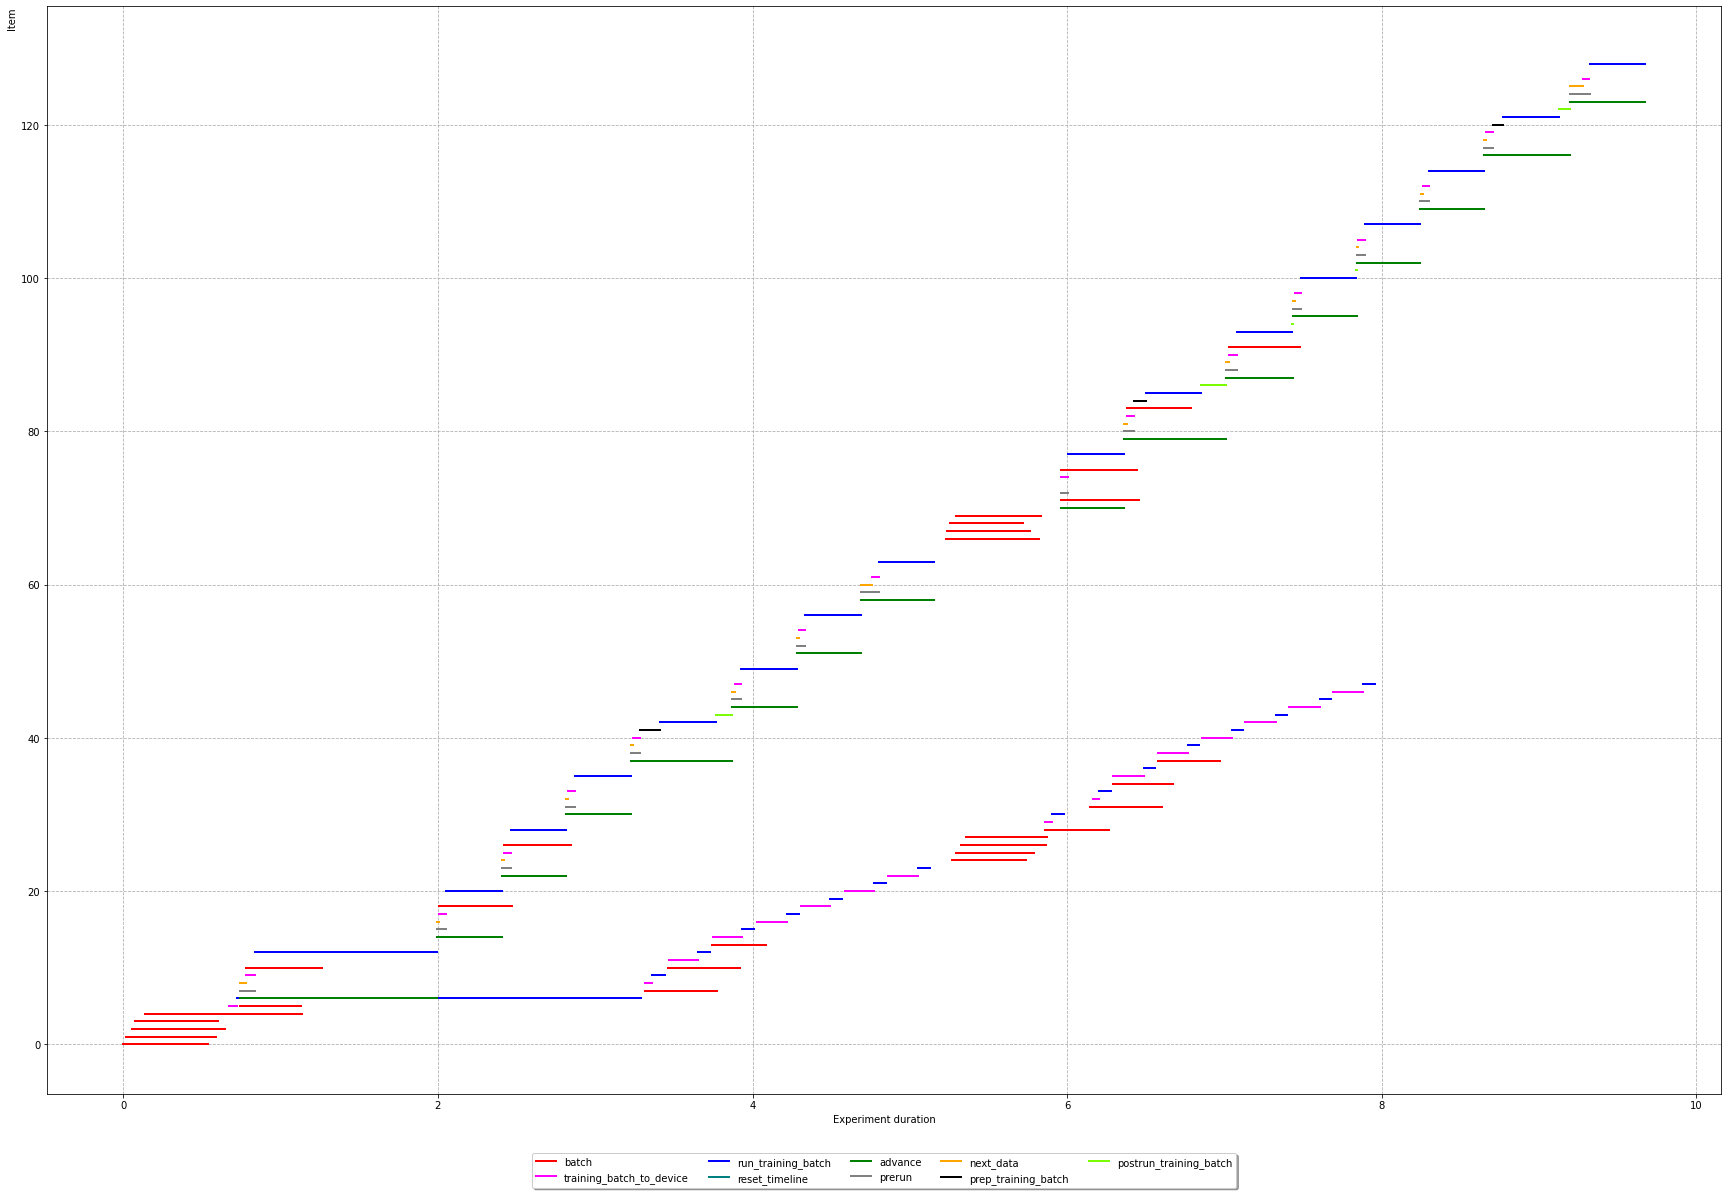

In [74]:
returns_scratch = []
fig, ax = plt.subplots(figsize=(30, 20))

for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
    df.drop_duplicates(subset="id", keep="first", inplace=True) 
    returns_scratch.append(timelines(df, run, lanes, colors, False, False, 7))

# df = df_dataloader_scratch[(df_dataloader_scratch["run"]=="20220211f100239_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync")]
# df.drop_duplicates(subset="id", keep="first", inplace=True) 
# returns_scratch.append(timelines(df, run, lanes, colors, False, False, 7))


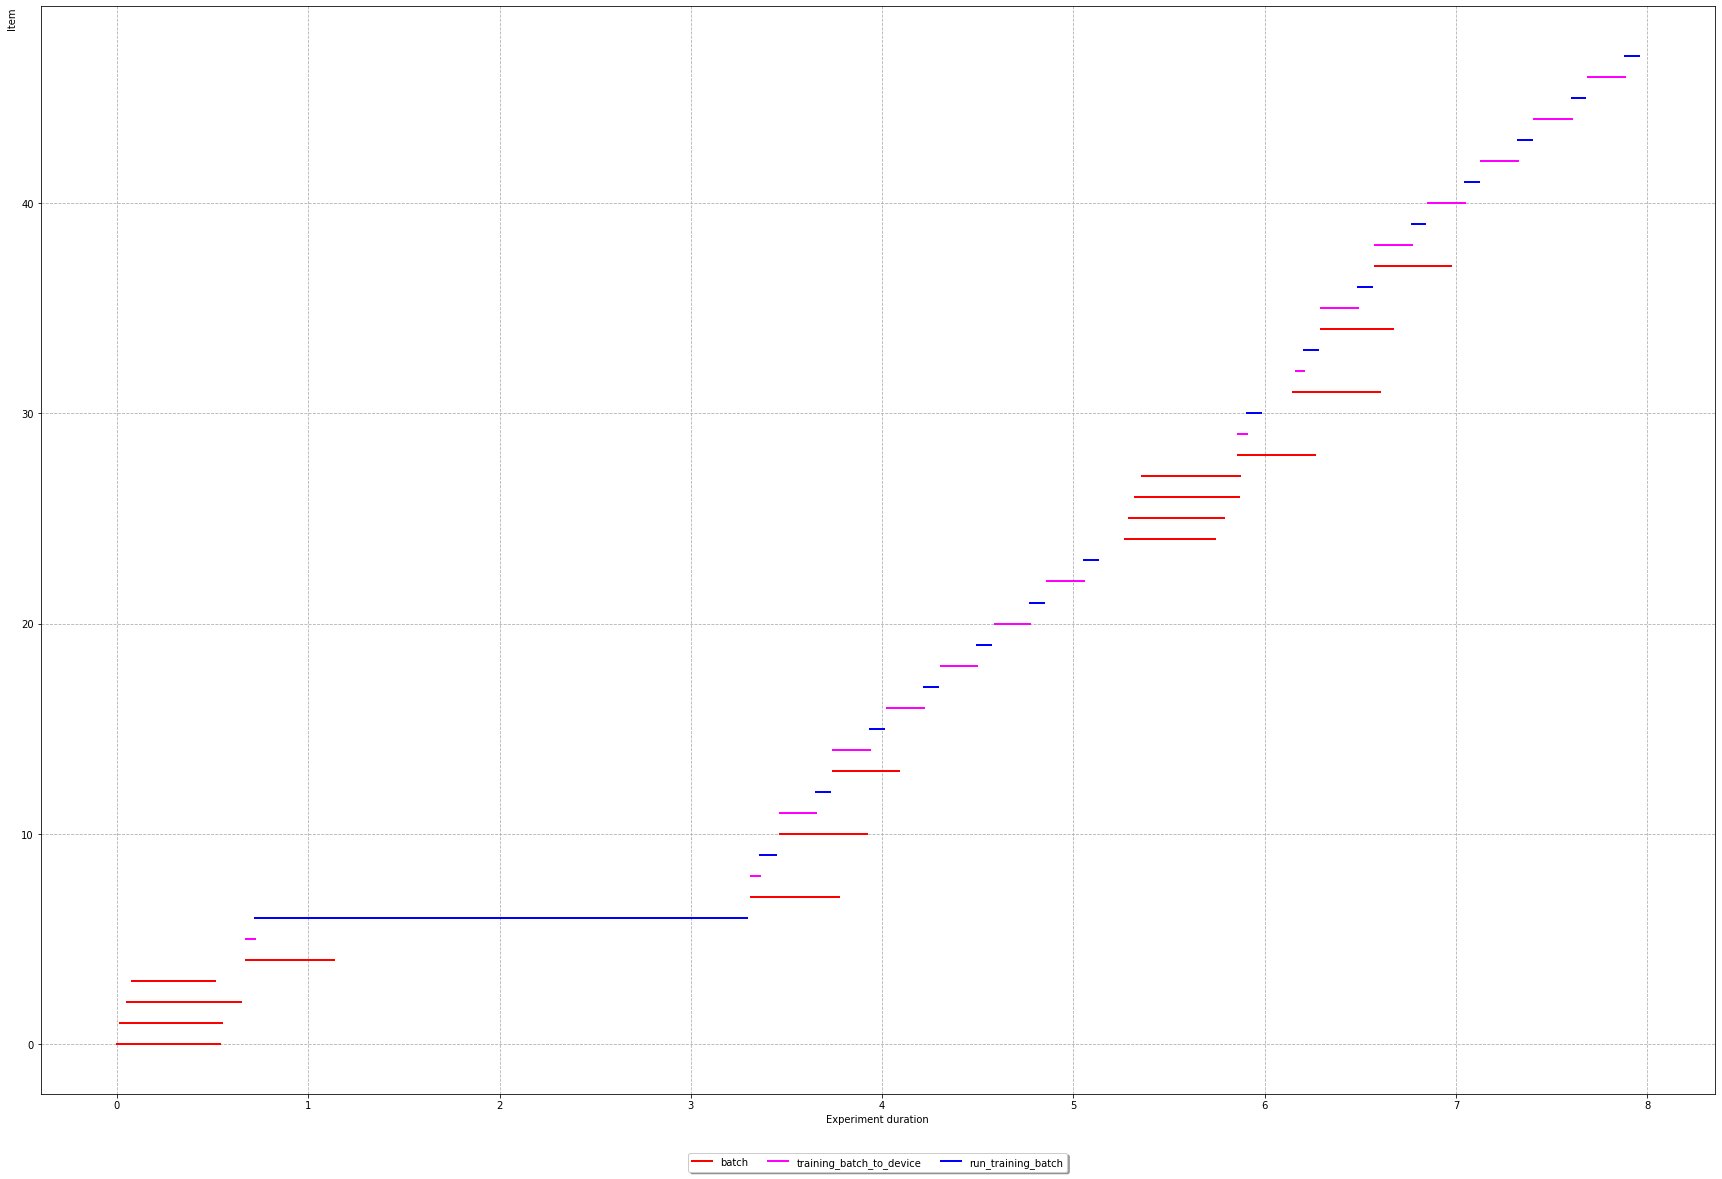

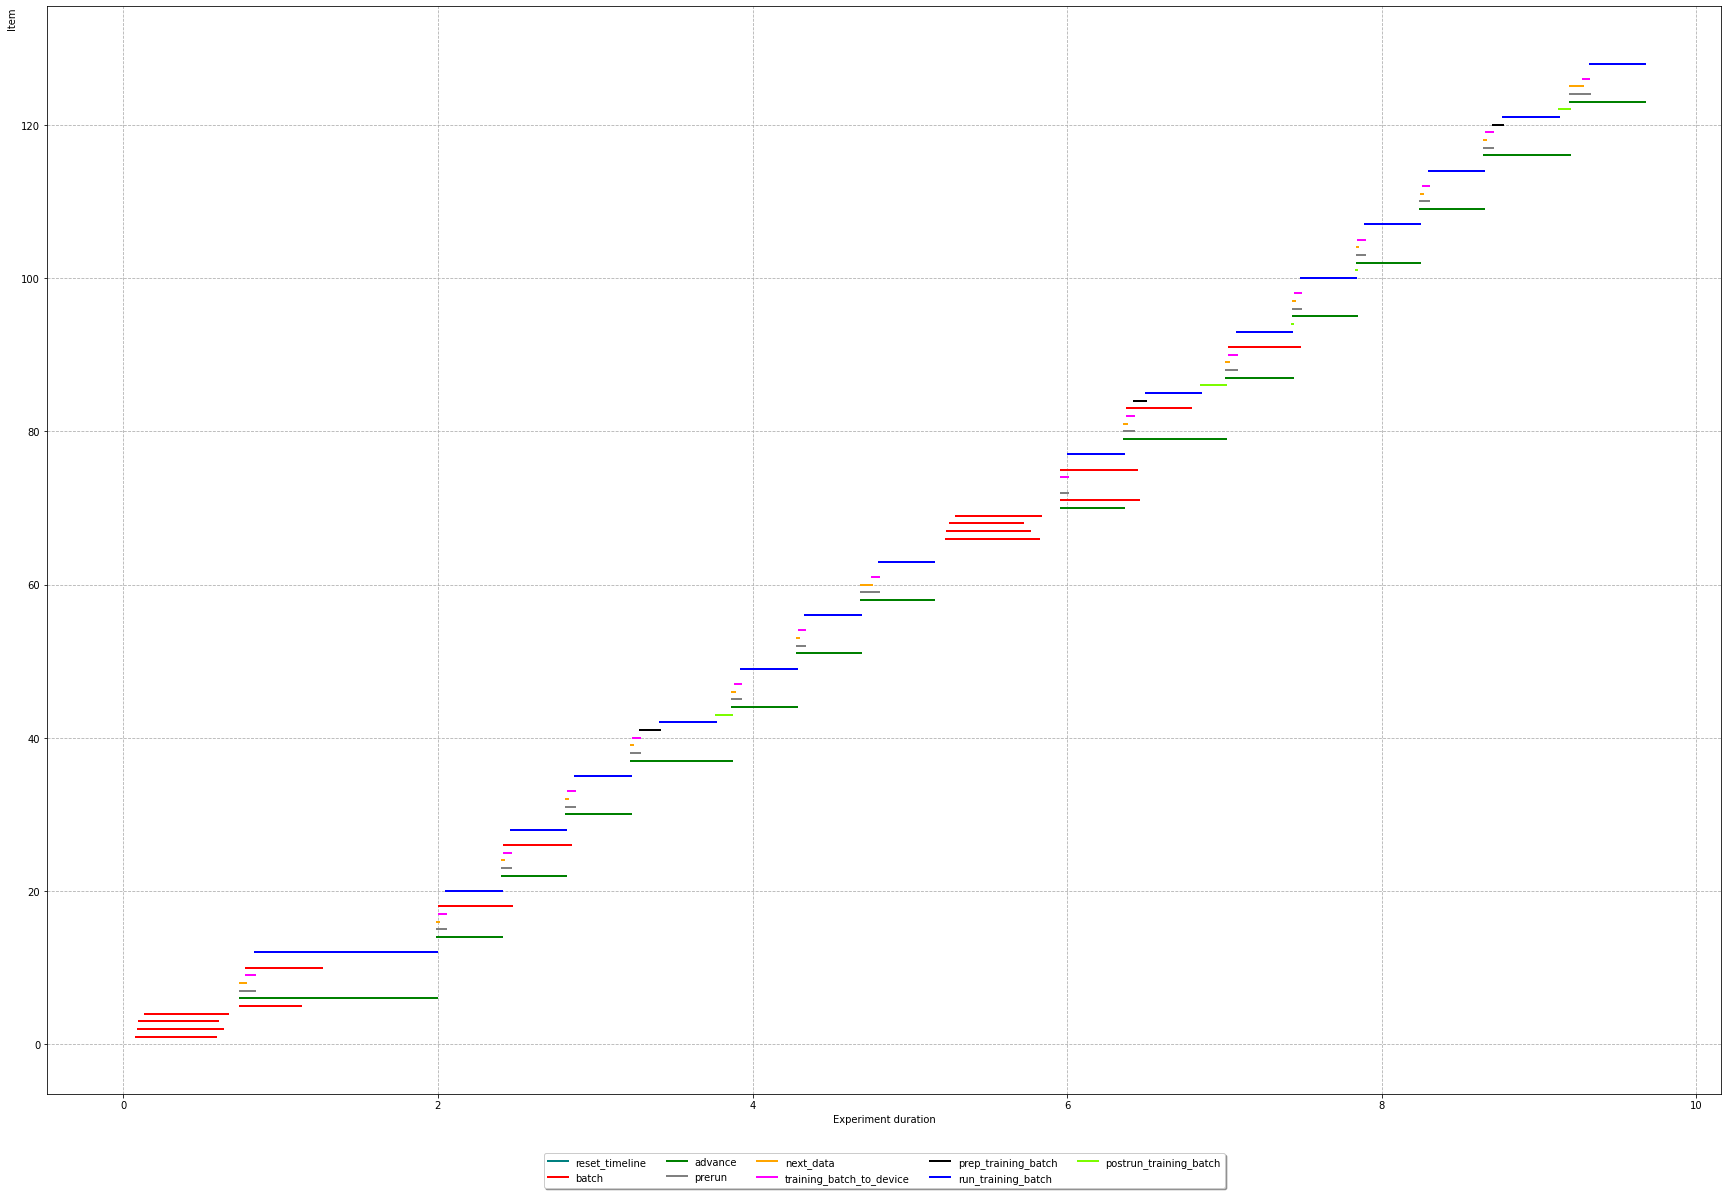

In [75]:
for run in sorted(unique_runs_scratch):
    fig, ax = plt.subplots(figsize=(30, 20))
    df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
    df.drop_duplicates(subset="id", keep="first", inplace=True) 
    returns_scratch.append(timelines(df, run, lanes, colors, False, False, 7))

### Reduced logging


```
tb_logger = pl_loggers.TensorBoardLogger(f"{output_base_folder}/lightning/")
profiler = SimpleProfiler(dirpath=f"{output_base_folder}/lightning/", filename=f"{str(time.time())}")
# profiler = None
if torch.cuda.device_count() > 0:
    trainer = pl.Trainer.from_argparse_args(
        args,
        max_epochs=args.epochs,
        profiler=profiler,
        checkpoint_callback=False,
        logger=tb_logger,
        log_every_n_steps=5,
        callbacks=[GPUStatsMonitor() if torch.cuda.device_count() > 0 else None],
    )
```
Replaced `log_every_n_steps=1000,` to reduce callbacks and `profiler = None`.


In [76]:
scratch_folder_filter="reduced_logging/*benchmark_e2e_*"
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 239.15it/s]


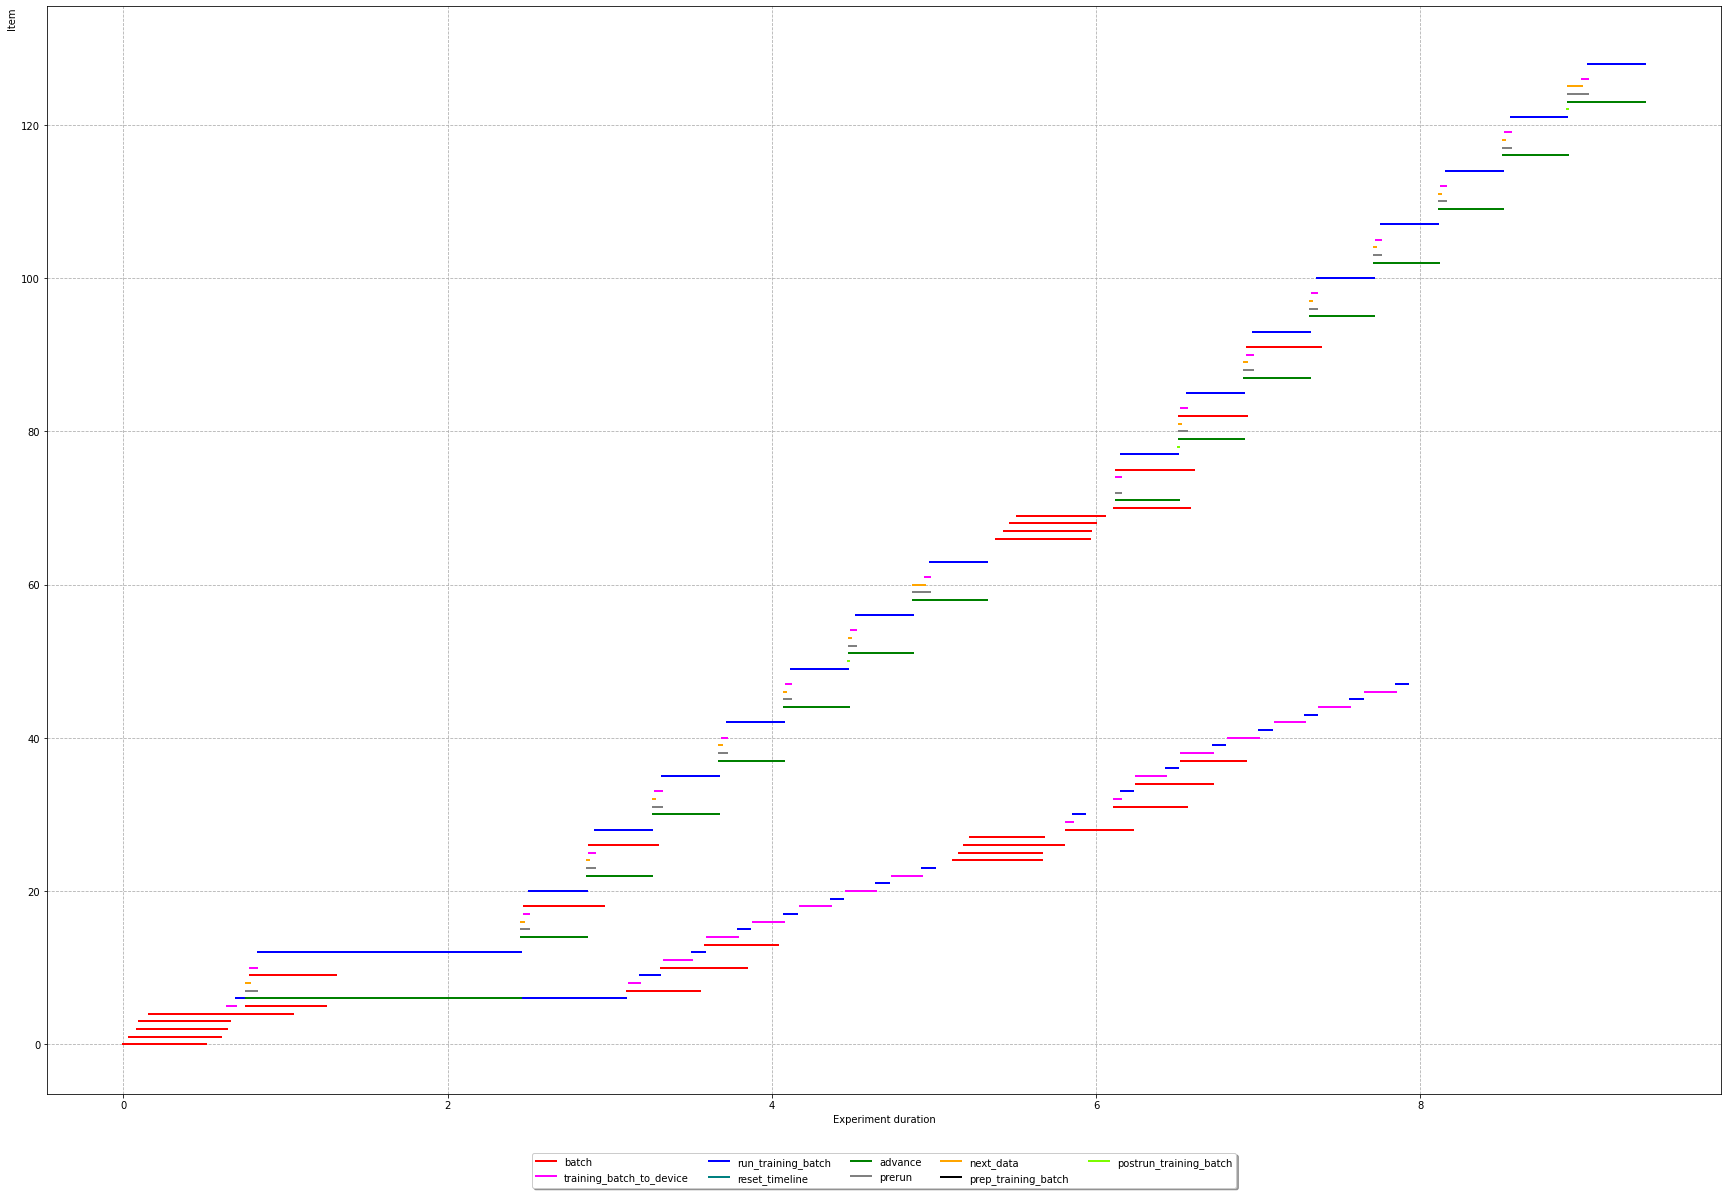

In [77]:
returns_scratch = []
fig, ax = plt.subplots(figsize=(30, 20))

for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
    df.drop_duplicates(subset="id", keep="first", inplace=True) 
    returns_scratch.append(timelines(df, run, lanes, colors, False, False, 7))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 242.84it/s]


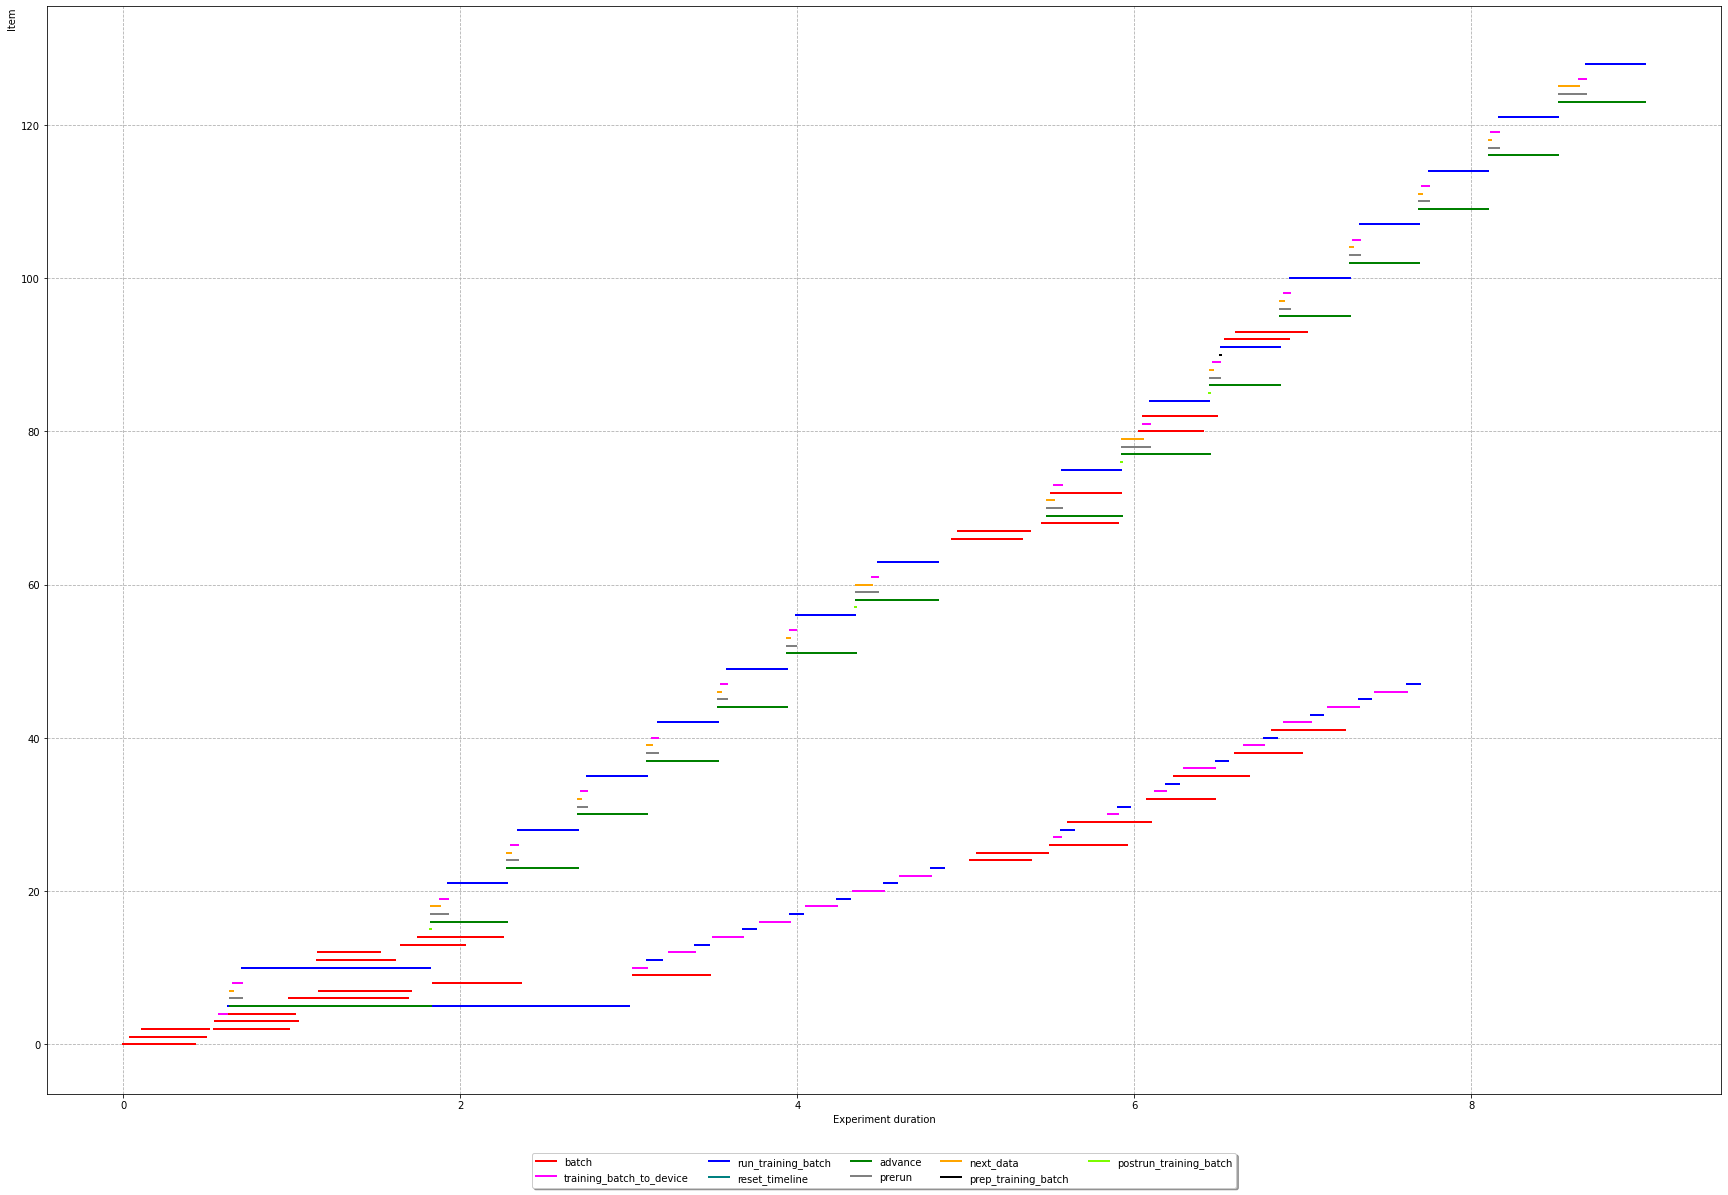

In [84]:
scratch_folder_filter="temp/*benchmark_e2e_*"
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

returns_scratch = []
fig, ax = plt.subplots(figsize=(30, 20))

for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
    df.drop_duplicates(subset="id", keep="first", inplace=True) 
    returns_scratch.append(timelines(df, run, lanes, colors, False, False, 7))